In [1]:
import math
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
def elo_probability(elo_a, elo_b):
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

In [3]:
def count_confusion_matrix(preds, true_labels):
    tp = sum(pred and true_label for pred, true_label in zip(preds, true_labels))
    tn = sum(not pred and not true_label for pred, true_label in zip(preds, true_labels))
    fp = sum(pred and not true_label for pred, true_label in zip(preds, true_labels))
    fn = sum(not pred and true_label for pred, true_label in zip(preds, true_labels))
    return tp, tn, fp, fn

In [4]:
def calculate_metrics(preds, true_labels):
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds)
    print("Accuracy:", round(accuracy, 2))

    # Calculate F1 score
    f1 = f1_score(true_labels, preds)
    print("F1 Score:", round(f1, 2))
    neg_f1 = f1_score(true_labels, preds, pos_label=0)
    print("Negative class F1 Score:", round(neg_f1, 2))

    # Calculate recall
    recall = recall_score(true_labels, preds)
    print("Recall:", round(recall, 2))
    neg_recall = recall_score(true_labels, preds, pos_label=0)
    print("Negative Class Recall:", round(neg_recall, 2))

    # Calculate precision
    precision = precision_score(true_labels, preds)
    print("Precision:", round(precision, 2))
    neg_precision = precision_score(true_labels, preds, pos_label=0)
    print("Negative Class Precision:", round(neg_precision, 2))

    # Confusion matrix
    tp, tn, fp, fn = count_confusion_matrix(preds, true_labels)
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

In [5]:
def balance_classes(X, y):
    num_ones = sum(y)
    num_zeros = len(y) - num_ones
    diff = num_ones - num_zeros
    indices_to_remove = [i for i in range(len(y)) if (y[i] == 1)][:diff] if diff > 0 else [i for i in range(len(y)) if (y[i] == 0)][:abs(diff)]
    X = [X[i] for i in range(len(X)) if i not in indices_to_remove]
    y = [y[i] for i in range(len(y)) if i not in indices_to_remove]
    return np.array(X), np.array(y)

In [6]:
with open("../data/training_data/inputs.json", "r") as file:
    X = np.array(json.load(file))
with open("../data/training_data/outputs.json", "r") as file:
    y = np.array(json.load(file), dtype=np.int8)
X, y = balance_classes(X, y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
X_train_original, X_test_original = X_train.copy(), X_test.copy()

scaler, scaler2 = MinMaxScaler(), MinMaxScaler()
#X_train, X_test = X_train[:,:2], X_test[:,:2]
# X_train, X_test = X_train[:,[0,1,5,6,10,11]], X_test[:,[0,1,5,6,10,11]]
X_train_small, X_test_small = X_train[:,[0,1]], X_test[:,[0,1]]
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_small = scaler2.fit_transform(X_train_small)
X_test_small = scaler2.transform(X_test_small)

In [8]:
sum(y_train) / len(y_train)

0.5018248175182481

In [23]:
n_bins = 16
test = False

In [24]:
# ELO based classifier
elo_probability_preds = []
if test:
    for row in X_test_original:
        elo_probability_preds.append(elo_probability(row[0], row[1]))
    elo_probability_preds = np.array(elo_probability_preds)
    elo_prob_true, elo_prob_pred = calibration_curve(y_test, elo_probability_preds, n_bins=n_bins, strategy='quantile')
    print(len(elo_probability_preds[elo_probability_preds > 0.5]), sum(y_test))
else:
    for row in X_train_original:
        elo_probability_preds.append(elo_probability(row[0], row[1]))
    elo_probability_preds = np.array(elo_probability_preds)
    elo_prob_true, elo_prob_pred = calibration_curve(y_train, elo_probability_preds, n_bins=n_bins, strategy='quantile')
    print(len(elo_probability_preds[elo_probability_preds > 0.5]), sum(y_train))
elo_preds = [1 if x > 0.5 else 0 for x in elo_probability_preds]

6462 6600


In [25]:
# Logistic regression
log_clf = LogisticRegression(random_state=42).fit(X_train, y_train)
log_clf_small = LogisticRegression(random_state=42).fit(X_train_small, y_train)

if test:
    log_preds = log_clf.predict(X_test)
    log_probability_preds = log_clf.predict_proba(X_test)[:,1]
    log_prob_true, log_prob_pred = calibration_curve(y_test, log_probability_preds, n_bins=n_bins, strategy='quantile')
    print(sum(log_preds), sum(y_test))

    log_preds_small = log_clf_small.predict(X_test_small)
    log_probability_preds_small = log_clf_small.predict_proba(X_test_small)[:,1]
    log_prob_true_small, log_prob_pred_small = calibration_curve(y_test, log_probability_preds_small, n_bins=n_bins, strategy='quantile')
else:
    log_preds = log_clf.predict(X_train)
    log_probability_preds = log_clf.predict_proba(X_train)[:,1]
    log_prob_true, log_prob_pred = calibration_curve(y_train, log_probability_preds, n_bins=n_bins, strategy='quantile')
    print(sum(log_preds), sum(y_train))

    log_preds_small = log_clf_small.predict(X_train_small)
    log_probability_preds_small = log_clf_small.predict_proba(X_train_small)[:,1]
    log_prob_true_small, log_prob_pred_small = calibration_curve(y_train, log_probability_preds_small, n_bins=n_bins, strategy='quantile')

6629 6600


In [26]:
# Random forest
rf_clf = RandomForestClassifier(random_state=42, max_depth=4).fit(X_train, y_train)

if test:
    rf_preds = rf_clf.predict(X_test)
    rf_probability_preds = rf_clf.predict_proba(X_test)[:,1]
    rf_prob_true, svc_prob_pred = calibration_curve(y_test, rf_probability_preds, n_bins=n_bins, strategy='quantile')
    print(sum(rf_preds), sum(y_test))
else:
    rf_preds = rf_clf.predict(X_train)
    rf_probability_preds = rf_clf.predict_proba(X_train)[:,1]
    rf_prob_true, rf_prob_pred = calibration_curve(y_train, rf_probability_preds, n_bins=n_bins, strategy='quantile')
    print(sum(rf_preds), sum(y_train))

6718 6600


In [27]:
# MLP
mlp_clf = MLPClassifier(random_state=42, activation='logistic').fit(X_train, y_train)

if test:
    mlp_preds = mlp_clf.predict(X_test)
    mlp_probability_preds = mlp_clf.predict_proba(X_test)[:,1]
    mlp_prob_true, svc_prob_pred = calibration_curve(y_test, mlp_probability_preds, n_bins=n_bins, strategy='quantile')
    print(sum(mlp_preds), sum(y_test))
else:
    mlp_preds = mlp_clf.predict(X_train)
    mlp_probability_preds = mlp_clf.predict_proba(X_train)[:,1]
    mlp_prob_true, mlp_prob_pred = calibration_curve(y_train, mlp_probability_preds, n_bins=n_bins, strategy='quantile')
    print(sum(mlp_preds), sum(y_train))

5867 6600


In [28]:
# # SVC
# svc_clf = SVC(random_state=42, probability=True, kernel="rbf").fit(X_train, y_train)

# if test:
#     svc_preds = svc_clf.predict(X_test)
#     svc_probability_preds = svc_clf.predict_proba(X_test)[:,1]
#     svc_prob_true, svc_prob_pred = calibration_curve(y_test, svc_probability_preds, n_bins=n_bins, strategy='quantile')
#     print(sum(svc_preds), sum(y_test))
# else:
#     svc_preds = svc_clf.predict(X_train)
#     svc_probability_preds = svc_clf.predict_proba(X_train)[:,1]
#     svc_prob_true, svc_prob_pred = calibration_curve(y_train, svc_probability_preds, n_bins=n_bins, strategy='quantile')
#     print(sum(svc_preds), sum(y_train))

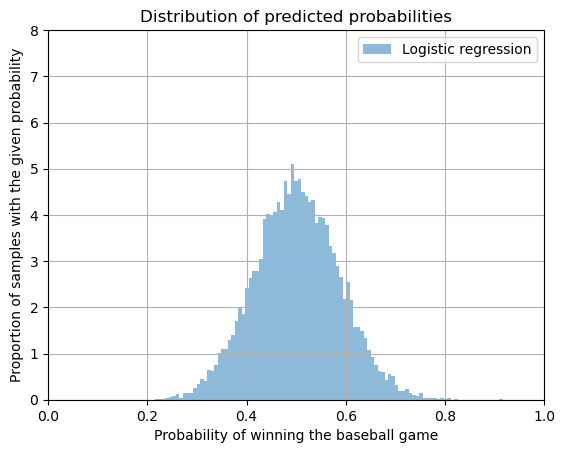

In [30]:
# plt.hist(elo_probability_preds, bins=100, density=True, label="ELO", alpha=0.5)
plt.hist(log_probability_preds, bins=100, density=True, label="Logistic regression", alpha=0.5)
# plt.hist(mlp_probability_preds, bins=100, density=True, label="MLP", alpha=0.5)
# plt.hist(rf_probability_preds, bins=100, density=True, label="Random forest", alpha=0.5)
# plt.hist(svc_probability_preds, bins=100, density=True, label="SVC", alpha=0.5)
plt.title("Distribution of predicted probabilities")
plt.legend()
plt.xlabel("Probability of winning the baseball game")
plt.ylabel("Proportion of samples with the given probability")
plt.ylim((0,8))
plt.xlim((0,1))
plt.grid()
plt.show()

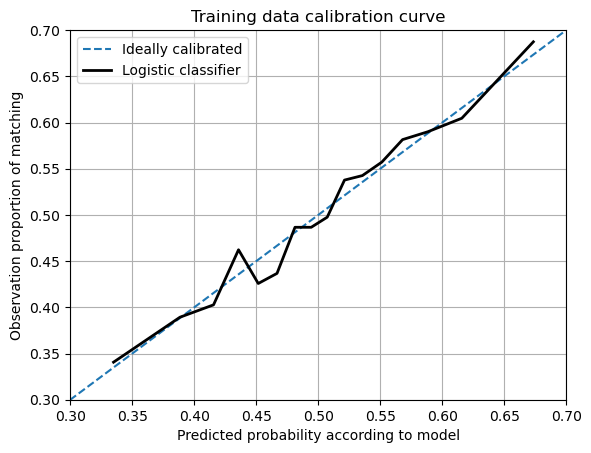

In [39]:
plt.plot([0, 1], [0, 1], linestyle = "--", label = "Ideally calibrated")
# plt.plot(elo_prob_pred, elo_prob_true, label="ELO classifier")
# plt.plot(svc_prob_pred, svc_prob_true, label="SVC classifier", alpha=0.5)
# plt.plot(mlp_prob_pred, mlp_prob_true, label="MLP", alpha=0.5)
# plt.plot(rf_prob_pred, rf_prob_true, label="Random forest", alpha=0.5)
plt.plot(log_prob_pred, log_prob_true, label="Logistic classifier", alpha=1, color="black", linewidth=2)
# plt.plot(log_prob_pred_small, log_prob_true_small, label="Logistic classifier small")

if test:
    plt.title("Test data calibration curves")
else:
    plt.title("Training data calibration curve")
plt.xlabel("Predicted probability according to model")
plt.ylabel("Observation proportion of matching")
plt.legend()
plt.grid()
plt.xlim((0.3,0.7))
plt.ylim((0.3,0.7))
plt.show()

In [17]:
print("Logistic regression metrics:")
if test:
    calculate_metrics(log_preds, y_test)
else:
    calculate_metrics(log_preds, y_train)

print("\nLogistic regression small metrics:")
if test:
    calculate_metrics(log_preds_small, y_test)
else:
    calculate_metrics(log_preds_small, y_train)

# print("\nSVC:")
# if test:
#     calculate_metrics(svc_preds, y_test)
# else:
#     calculate_metrics(svc_preds, y_train)

print("\nRandom forest metrics:")
if test:
    calculate_metrics(rf_preds, y_test)
else:
    calculate_metrics(rf_preds, y_train)

print("\nMLP metrics:")
if test:
    calculate_metrics(mlp_preds, y_test)
else:
    calculate_metrics(mlp_preds, y_train)

print("\nELO model metrics:")
if test:
    calculate_metrics(elo_preds, y_test)
else:
    calculate_metrics(elo_preds, y_train)

Logistic regression metrics:
Accuracy: 0.57
F1 Score: 0.58
Negative class F1 Score: 0.57
Recall: 0.58
Negative Class Recall: 0.57
Precision: 0.57
Negative Class Precision: 0.57
TP: 3811, TN: 3734, FP: 2818, FN: 2789

Logistic regression small metrics:
Accuracy: 0.57
F1 Score: 0.57
Negative class F1 Score: 0.56
Recall: 0.57
Negative Class Recall: 0.56
Precision: 0.57
Negative Class Precision: 0.57
TP: 3786, TN: 3678, FP: 2874, FN: 2814

Random forest metrics:
Accuracy: 0.59
F1 Score: 0.6
Negative class F1 Score: 0.59
Recall: 0.6
Negative Class Recall: 0.58
Precision: 0.59
Negative Class Precision: 0.59
TP: 3973, TN: 3807, FP: 2745, FN: 2627

MLP metrics:
Accuracy: 0.57
F1 Score: 0.55
Negative class F1 Score: 0.59
Recall: 0.52
Negative Class Recall: 0.63
Precision: 0.58
Negative Class Precision: 0.56
TP: 3423, TN: 4108, FP: 2444, FN: 3177

ELO model metrics:
Accuracy: 0.57
F1 Score: 0.56
Negative class F1 Score: 0.57
Recall: 0.56
Negative Class Recall: 0.58
Precision: 0.57
Negative Class

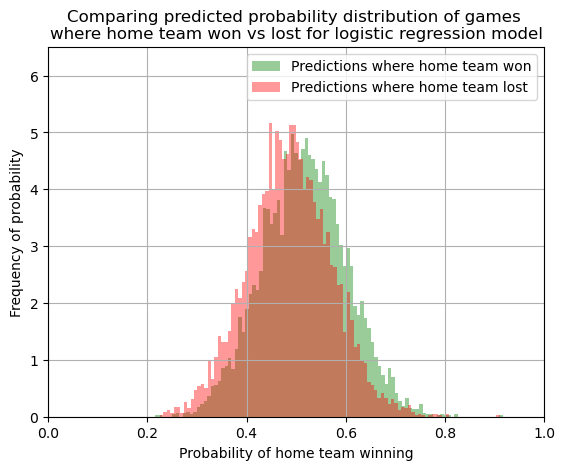

In [48]:
preds = log_probability_preds
label = "logistic regression"
if test:
    plt.hist(preds[y_test == 1], bins=100, density=True, color='green', alpha=0.4, label="Correct predictions")
    plt.hist(preds[y_test == 0], bins=100, density=True, color='red', alpha=0.4, label="Wrong predictions")
else:
    plt.hist(preds[y_train == 1], bins=100, density=True, color='green', alpha=0.4, label="Predictions where home team won")
    plt.hist(preds[y_train == 0], bins=100, density=True, color='red', alpha=0.4, label="Predictions where home team lost")
plt.ylabel("Frequency of probability")
plt.xlabel("Probability of home team winning")
plt.xlim((0,1))
plt.ylim((0,6.5))
plt.title("Comparing predicted probability distribution of games \nwhere home team won vs lost for " + label + " model")
plt.grid()
plt.legend()
plt.show()

In [19]:
log_clf.coef_, log_clf.intercept_

(array([[ 1.29882748, -1.41828502,  0.32381695,  0.72864562, -0.12292611,
         -0.20987506, -0.93143971,  0.70342289, -0.59611982,  0.0882926 ,
          0.23631698,  1.73377966]]),
 array([-0.18498338]))

In [20]:
pt = np.array([1500,1500, 4,3,3,1,1, 4,3,1,1,1]).reshape(1,-1)
log_clf.predict_proba(scaler.transform(pt))

array([[0.5097245, 0.4902755]])

In [21]:
# Save models
with open("../data/model_data/scaler_model.p", "wb") as file:
    pickle.dump(scaler, file)
with open("../data/model_data/main_model.p", "wb") as file:
    pickle.dump(log_clf, file)